## import

In [1]:
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
%matplotlib inline
import seaborn as sns
import warnings
import plotly.express as px
warnings.filterwarnings('ignore')

## 데이터 불러오기

In [2]:
train = pd.read_csv('Dataset/train.csv')
test = pd.read_csv('Dataset/test.csv')
data_info = pd.read_csv('Dataset/data_info.csv')

## 데이터 정보

In [3]:
data_info

,변수명,변수 설명
0,id,아이디
1,base_date,날짜
2,day_of_week,요일
3,base_hour,시간대
4,road_in_use,도로사용여부
5,lane_count,차로수
6,road_rating,도로등급
7,multi_linked,중용구간 여부
8,connect_code,연결로 코드
9,maximum_speed_limit,최고속도제한


In [4]:
column_names = train.columns.values.tolist()

for i in column_names:
    print(f"{i} = {train[i].nunique()}")
# 총 61개의 도로, 586개의 시작/도착 (위경도), 487개의 시작/도착 도로명 

id = 4701217
base_date = 281
day_of_week = 7
base_hour = 24
lane_count = 3
road_rating = 3
road_name = 61
multi_linked = 2
connect_code = 2
maximum_speed_limit = 6
vehicle_restricted = 1
weight_restricted = 4
height_restricted = 1
road_type = 2
start_node_name = 487
start_latitude = 586
start_longitude = 586
start_turn_restricted = 2
end_node_name = 487
end_latitude = 586
end_longitude = 586
end_turn_restricted = 2
target = 102


In [22]:
train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0


## 1. road_name 결측치 처리

In [20]:
train['road_name'].value_counts().sum()

4701217

In [15]:
road_name_null = train.groupby([train['road_name'] == '-'])['road_name'].value_counts()
road_name_null

road_name  road_name
False      일반국도12호선     1046092
           일반국도16호선      554510
           일반국도95호선      248181
           일반국도11호선      215701
           지방도1132호선     179200
                         ...   
           아봉로             7342
           남조로             6813
           호서중앙로           2819
           호근로              587
True       -             569463
Name: road_name, Length: 61, dtype: int64

In [18]:
road_name_null.nunique()

60

<AxesSubplot:ylabel='road_name'>

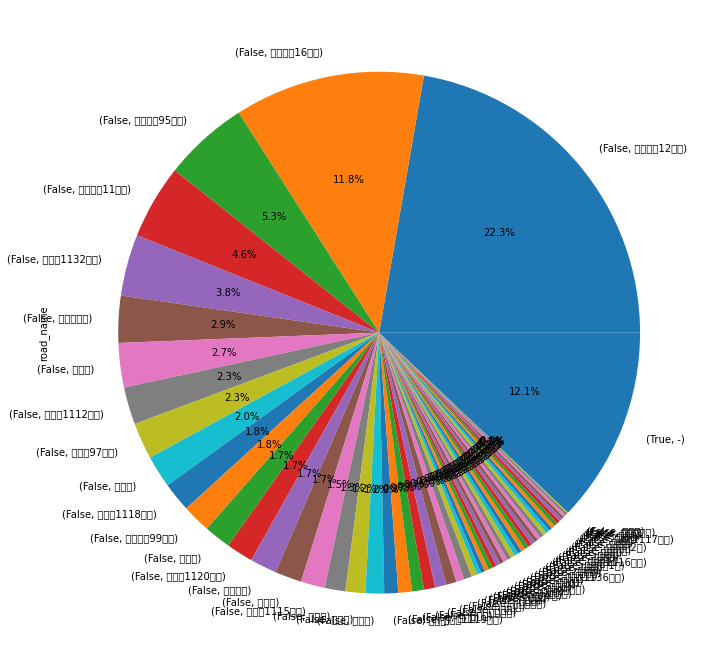

In [24]:
road_name_null.plot(kind = 'pie', autopct = '%.1f%%', figsize=(16, 12))

## 2. 값이 유일한 컬럼

In [27]:
train_desc = train.describe().transpose()
train_desc[train_desc['std']==0].index

Index(['vehicle_restricted', 'height_restricted'], dtype='object')

array([[<AxesSubplot:title={'center':'vehicle_restricted'}>,
        <AxesSubplot:title={'center':'height_restricted'}>]], dtype=object)

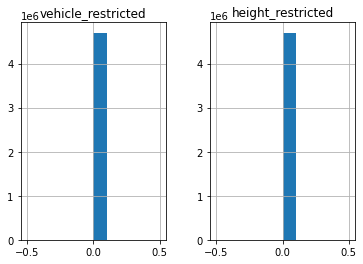

In [26]:
train[['vehicle_restricted', 'height_restricted']].hist()

## 3. Target Encoding

- 상관계수가 높은 컬럼이 많이 않아서 인코딩을 해야겠다고 생각
- One-Hot 인코딩을 할 경우 새로운 컬럼이 너무 많이 생기게 되고 High Cardinality 피처를 모델에 너무 불균형하게 중요하게 만들어 Column Sampling 과정에 안 좋은 영향을 끼침
- 그래서 Target Encoding 방식 이용

<AxesSubplot:>

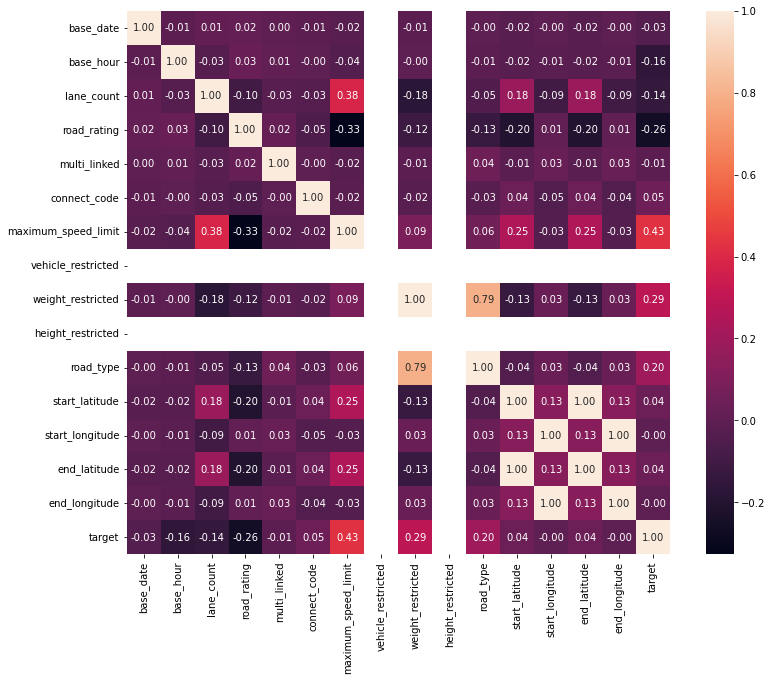

In [28]:
train_corr = train.corr()
f, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(train_corr, annot=True, fmt = '.2f', square=True)

#### 장점 (label 인코딩과 비교했을 때)
- ① label 인코딩의 경우 1000개의 데이터면 1000개의 label이 생기는데 Mean target 인코딩은 카테고리 종류의 수만큼 label이 생기므로 더욱 적은 split이 생기고 학습이 더욱 빠르게 이루어집니다.
- ② 인코딩된 label값이 target값과 관련된 의미를 가지게 되었으므로 less bias를 가집니다.

#### 단점

- ① 구현과 검증이 까다롭습니다.
- ② 오버피팅이 일어나기 쉽습니다.

## 4. 제주 권역별 범주화 후 좌표 별 도시 범주화

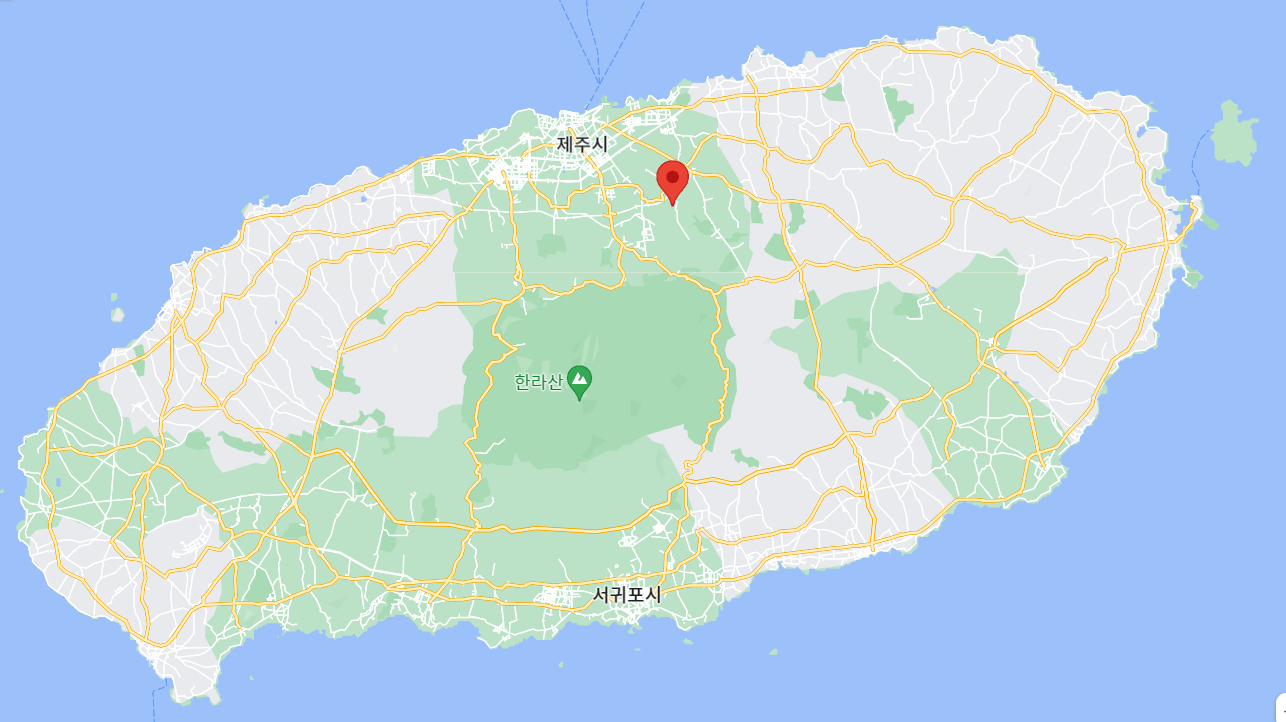

## 5. 시즌 컬럼 추가

- 월별 속도 바플롯

In [43]:
train["base_date"] = pd.to_datetime(train["base_date"],format='%Y%m%d')
train['year']= train['base_date'].dt.year
train['month']= train['base_date'].dt.month
train['day']= train['base_date'].dt.day

<AxesSubplot:xlabel='month', ylabel='target'>

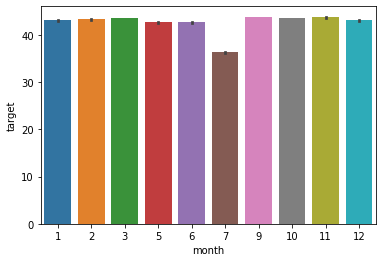

In [48]:
sns.barplot(data=train, x='month', y='target')

## 6. work_or_rest_or_other 컬럼 추가

- 시간별 속도 바플롯

<AxesSubplot:xlabel='base_hour', ylabel='target'>

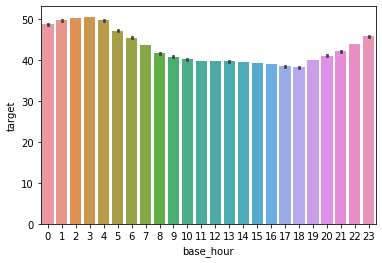

In [46]:
sns.barplot(data=train, x='base_hour', y='target')

## 7. 라벨인코더 

In [49]:
train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,year,month,day
0,TRAIN_0000000,2022-06-23,목,17,1,106,지방도1112호선,0,0,60.0,...,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0,2022,6,23
1,TRAIN_0000001,2022-07-28,목,21,2,103,일반국도11호선,0,0,60.0,...,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0,2022,7,28
2,TRAIN_0000002,2021-10-10,일,7,2,103,일반국도16호선,0,0,80.0,...,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0,2021,10,10
3,TRAIN_0000003,2022-03-11,금,13,2,107,태평로,0,0,50.0,...,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0,2022,3,11
4,TRAIN_0000004,2021-10-05,화,8,2,103,일반국도12호선,0,0,80.0,...,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0,2021,10,5


---

<AxesSubplot:xlabel='start_longitude', ylabel='start_latitude'>

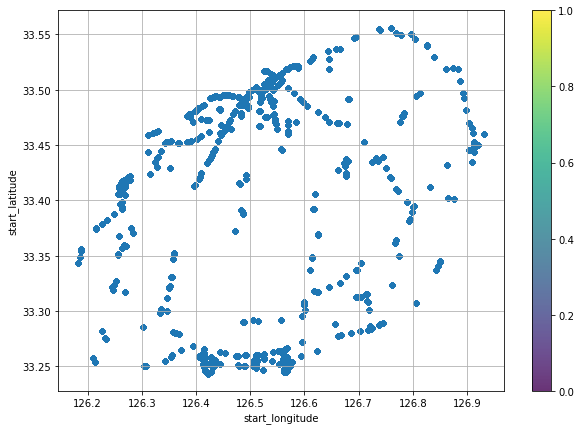

In [54]:
train.plot(kind='scatter', x='start_longitude', y='start_latitude', alpha=0.8, grid=True,
              cmap='jet', colorbar=True, figsize=(10, 7), sharex=False)